In [1]:
import iris
import numpy as np
from iris.coords import DimCoord
from iris.coord_systems import TransverseMercator,GeogCS
from iris.cube import Cube
from cf_units import Unit
import cf_units
import os
import glob
from pyproj import Proj, transform
import sys
import warnings
import multiprocessing as mp

warnings.filterwarnings("ignore")

ems_hourly = ['01', '04', '06', '07', '08', '09', '10', '11', '12', '13', '15']
ems_30mins = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc013',  'bc015',  'bc016', 'bc017', 'bc018', 'bc012']
yrs_range = '1980_2001'

In [40]:
##########################################################################################
#########################################################################################
# Define variables and set up environment
##########################################################################################
##########################################################################################
root_fp = "/nfs/a319/gy17m2a/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'PhD/Scripts/DataProcessing/Regridding')
from Regridding_functions import *
# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

gb_gdf = create_gb_outline({'init' :'epsg:3857'})

# Load UKCP18 12km model data to use in regriddding
file_model_12km=f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/01/{yrs_range}/pr_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc'
cube_12km=iris.load_cube(file_model_12km)

file_model_2_2km ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/01/1980_2001/pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc'
cube_model_2_2km =iris.load_cube(file_model_2_2km)

In [3]:
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
cube_12km_trimmed_to_leeds =  trim_to_bbox_of_region_obs(cube_12km, leeds_at_centre_gdf)

## Regrid hourly UKCP18 data to 12km - DONE

In [4]:
yrs_range = '1980_2001'
# ems_hourly = ['04', '06', '07', '08', '09', '10', ]

In [10]:
cube = iris.load(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/05/1980_2001/pr_rcp85_land-cpm_uk_2.2km_05_1hr_19850801-19850830.nc")[0]

In [11]:
source_crs = ccrs.OSGB(approx=False)
target_crs = ccrs.Geodetic()

regridded_cube = cube.regrid(cube_12km, iris.analysis.Linear())

In [21]:
cube.coord('grid_latitude').shape

(606,)

In [24]:
cube.coord('latitude').shape

(606, 484)

In [27]:
cube.coord('longitude')

AuxCoord(masked_array(
  data=[[-11.45570495, -11.40304412, -11.3503741 , ...,   3.76826807,
           3.82132352,   3.87432739],
        [-11.46230506, -11.40960628, -11.3568983 , ...,   3.77291428,
           3.82600861,   3.87905132],
        [-11.46891414, -11.41617738, -11.36343138, ...,   3.77756688,
           3.83070015,   3.88378174],
        ...,
        [-14.57104409, -14.50075302, -14.43043775, ...,   5.97000315,
           6.04134176,   6.11260221],
        [-14.58311353, -14.51275538, -14.44237295, ...,   5.97857125,
           6.04998038,   6.12131122],
        [-14.59520908, -14.52478371, -14.45433399, ...,   5.98715822,
           6.05863801,   6.1300394 ]],
  mask=False,
  fill_value=1e+20), standard_name='longitude', units=Unit('degrees'), var_name='longitude')

In [14]:
cube_12km.coord('projection_y_coordinate').shape

(112,)

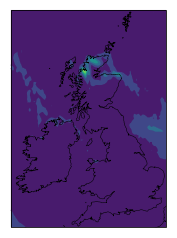

In [46]:
iplt.contourf(cube_12km[0,1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [45]:
cube = trim_to_bbox_of_region_regriddedobs(cube, gb_gdf)
cube_12km = trim_to_bbox_of_region_obs(cube_12km, gb_gdf)

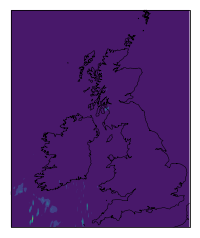

In [44]:
iplt.contourf(cube[0,1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [47]:
print(np.nanmin(cube_12km.coord('grid_latitude').points))
print(np.nanmin(cube.coord('latitude').points))

0.2926499085124958
49.48733913085226


In [48]:
print(np.nanmin(cube_12km.coord('grid_longitude').points))
print(np.nanmin(cube.coord('longitude').points))

-17.986626752055315
-14.595209076981911


In [31]:
import iris
from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear

# Load your curvilinear grid cube (source)
curvilinear_cube = cube

# Load or define your target rectilinear grid cube
rectilinear_cube = cube_12km

# Perform the regridding
# regridded_cube = regrid_weighted_curvilinear_to_rectilinear(curvilinear_cube, rectilinear_cube)
# Perform the regridding
regridded_cube = regrid_weighted_curvilinear_to_rectilinear(cube,None, cube_12km)

CoordinateNotFoundError: 'Expected to find exactly 1 coordinate, but found 2. They were: grid_longitude, longitude.'

In [26]:
import iris.util

# Promote grid_latitude and grid_longitude to dimension coordinates
cube_12km = iris.util.promote_aux_coord_to_dim_coord(cube_12km, 'grid_latitude')
cube_12km = iris.util.promote_aux_coord_to_dim_coord(cube_12km, 'grid_longitude')
cube_12km

ValueError: Attempting to promote an AuxCoord (grid_latitude) which is associated with 2 dimensions.

In [18]:
cube_12km#.coord('latitude')

Lwe Precipitation Rate (mm/day),ensemble_member,time,projection_y_coordinate,projection_x_coordinate
Shape,1,3600,112,82
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
projection_y_coordinate,-,-,x,-
projection_x_coordinate,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


In [19]:
cube#.coord('latitude')

Lwe Precipitation Rate (mm/hour),ensemble_member,time,grid_latitude,grid_longitude
Shape,1,720,606,484
Dimension coordinates,,,,
ensemble_member,x,-,-,-
time,-,x,-,-
grid_latitude,-,-,x,-
grid_longitude,-,-,-,x
Auxiliary coordinates,,,,
ensemble_member_id,x,-,-,-
month_number,-,x,-,-
year,-,x,-,-


In [15]:
import iris
from iris.analysis import AreaWeighted

# Assuming cube is your source and cube_12km is the target with a more complex projection system

# Define the regridding scheme
regrid_scheme = AreaWeighted()

# Perform regridding
regridded_cube = cube.regrid(cube_12km, regrid_scheme)

# regridded_cube now contains data from cube regridded onto the spatial grid of cube_12km

ValueError: The horizontal grid coordinates of both the source and grid cubes must have the same coordinate system.

In [10]:
latitude_coord_system = cube.coord('grid_latitude').coord_system
longitude_coord_system = cube.coord('grid_longitude').coord_system

print("Latitude Coordinate System:", latitude_coord_system)
print("Longitude Coordinate System:", longitude_coord_system)


Latitude Coordinate System: RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0))
Longitude Coordinate System: RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0))


In [14]:
latitude_coord_system = cube_12km.coord('latitude').coord_system
longitude_coord_system = cube_12km.coord('projection_x_coordinate').coord_system

print("Latitude Coordinate System:", latitude_coord_system)
print("Longitude Coordinate System:", longitude_coord_system)


CoordinateNotFoundError: 'Expected to find exactly 1 latitude coordinate, but found none.'

In [6]:
for em in ['05']:
    print(em)
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/{em}/{yrs_range}/")
    output_fp = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km_regridded_12km/{em}/NearestNeighbour/{yrs_range}/"
    if not os.path.isdir(output_fp):
        os.makedirs(output_fp)
    for filename in glob.glob("*"):     
            if filename[47:49] in ['06', '07', '08']:
                if os.path.isfile(output_fp +  f"rg_{filename}_aw"):
                    print("already exist")
                else:
                    print(filename)
                    cube = iris.load(filename)[0]
                    # Linear interpolation
                    #reg_cube_lin =cube.regrid(cube_model,iris.analysis.Linear())      
                    # Nearest neighbour
                    reg_cube_nn =cube.regrid(cube_12km,iris.analysis.AreaWeighted())   
                    # Save 
                    iris.save(reg_cube_nn, output_fp +  f"rg_{filename}_aw")     

05
pr_rcp85_land-cpm_uk_2.2km_05_1hr_20160801-20160830.nc


ValueError: The horizontal grid coordinates of both the source and grid cubes must have the same coordinate system.

## Regrid 30 mins UKCP18 data to 12km - DONE
For this need to use version of the regridding cube which is trimmed to the leeds-at-centre region, as the 30 mins data is already clipped to this extent

In [12]:
ems_30mins =  ['bc005',  'bc006',  'bc007', 'bc009',  'bc010', 
       'bc011', 'bc013',  'bc015',  'bc016',  'bc017', 'bc018', 'bc012']

In [14]:
for em in ems_30mins:
    print(em)
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km/{em}/2002_2020/")
    output_fp = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_regridded_12km/{em}/NearestNeighbour/2002_2020/"
    if not os.path.isdir(output_fp):
        os.makedirs(output_fp)
    for filename in np.sort(glob.glob("*")):   
        print(filename)
        if not os.path.isfile(output_fp +  f"rg_{filename}"):
            print("creating")
            # print(filename)
            cube = iris.load(filename)[0]
            # Linear interpolation
            #reg_cube_lin =cube.regrid(cube_model,iris.analysis.Linear())      
            # Nearest neighbour
            try:
                reg_cube_nn =cube.regrid(cube_12km_trimmed_to_leeds,iris.analysis.Nearest())   
            except:
                print("Didnt work")
                pass
            # print(reg_cube_nn.shape)
            # Save 
            iris.save(reg_cube_nn, output_fp +  f"rg_{filename}") 
        else:
            print("already exists")

bc005
bc005a.pr200006.nc
already exists
bc005a.pr200007.nc
already exists
bc005a.pr200008.nc
already exists
bc005a.pr200106.nc
already exists
bc005a.pr200107.nc
already exists
bc005a.pr200108.nc
already exists
bc005a.pr200206.nc
already exists
bc005a.pr200207.nc
already exists
bc005a.pr200208.nc
already exists
bc005a.pr200306.nc
already exists
bc005a.pr200307.nc
already exists
bc005a.pr200308.nc
already exists
bc005a.pr200406.nc
already exists
bc005a.pr200407.nc
already exists
bc005a.pr200408.nc
already exists
bc005a.pr200506.nc
already exists
bc005a.pr200507.nc
already exists
bc005a.pr200508.nc
already exists
bc005a.pr200606.nc
already exists
bc005a.pr200607.nc
already exists
bc005a.pr200608.nc
already exists
bc005a.pr200706.nc
already exists
bc005a.pr200707.nc
already exists
bc005a.pr200708.nc
already exists
bc005a.pr200806.nc
already exists
bc005a.pr200807.nc
already exists
bc005a.pr200808.nc
already exists
bc005a.pr200906.nc
already exists
bc005a.pr200907.nc
already exists
bc005a.p

already exists
bc010a.pr200708.nc
already exists
bc010a.pr200806.nc
already exists
bc010a.pr200807.nc
already exists
bc010a.pr200808.nc
already exists
bc010a.pr200906.nc
already exists
bc010a.pr200907.nc
already exists
bc010a.pr200908.nc
already exists
bc010a.pr201006.nc
already exists
bc010a.pr201007.nc
already exists
bc010a.pr201008.nc
already exists
bc010a.pr201106.nc
already exists
bc010a.pr201107.nc
already exists
bc010a.pr201108.nc
already exists
bc010a.pr201206.nc
already exists
bc010a.pr201207.nc
already exists
bc010a.pr201208.nc
already exists
bc010a.pr201306.nc
already exists
bc010a.pr201307.nc
already exists
bc010a.pr201308.nc
already exists
bc010a.pr201406.nc
already exists
bc010a.pr201407.nc
already exists
bc010a.pr201408.nc
already exists
bc010a.pr201506.nc
already exists
bc010a.pr201507.nc
already exists
bc010a.pr201508.nc
already exists
bc010a.pr201606.nc
already exists
bc010a.pr201607.nc
already exists
bc010a.pr201608.nc
already exists
bc010a.pr201706.nc
already exists

already exists
bc016a.pr201407.nc
already exists
bc016a.pr201408.nc
already exists
bc016a.pr201506.nc
already exists
bc016a.pr201507.nc
already exists
bc016a.pr201508.nc
already exists
bc016a.pr201606.nc
already exists
bc016a.pr201607.nc
already exists
bc016a.pr201608.nc
already exists
bc016a.pr201706.nc
already exists
bc016a.pr201707.nc
already exists
bc016a.pr201708.nc
already exists
bc016a.pr201806.nc
already exists
bc016a.pr201807.nc
already exists
bc016a.pr201808.nc
already exists
bc016a.pr201906.nc
already exists
bc016a.pr201907.nc
already exists
bc016a.pr201908.nc
already exists
bc016a.pr202006.nc
already exists
bc016a.pr202007.nc
already exists
bc016a.pr202008.nc
already exists
bc017
bc017a.pr200006.nc
already exists
bc017a.pr200007.nc
already exists
bc017a.pr200008.nc
already exists
bc017a.pr200106.nc
already exists
bc017a.pr200107.nc
already exists
bc017a.pr200108.nc
already exists
bc017a.pr200206.nc
already exists
bc017a.pr200207.nc
already exists
bc017a.pr200208.nc
already 

## Regrid NIMROD - DONE

In [5]:
for year in range(2012,2013):
    print(year)
    # Change directory to be for correct year
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/OriginalFormat_1km/{year}")
    # Define filepaths to save files to
    output_dir_12km = f"/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/NIMROD_regridded_12km/NearestNeighbour/{year}/"
    output_dir_2_2km = f"/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/NIMROD_regridded_2.2km/NearestNeighbour/{year}/"
    # Create these directories if they don't exist already
    if not os.path.isdir(output_dir_12km):
        os.makedirs(output_dir_12km)
    if not os.path.isdir(output_dir_2_2km):
        os.makedirs(output_dir_2_2km)
    # Loop through all the diles in the 1km folder    
    for filename in sorted(glob.glob("*")):
        if filename != 'metoffice-c-band-rain-radar_uk_20090728_30mins.nc':
            print(filename)
            # Create version of filename specifying it is regridded
            filename_to_save_to = f"rg_{filename}"

            # Check if this regridded file exists, and if not create it
            # Don't want to load the cube twice unnecessarily, so if we load it for 12km, then make a flag to tell us it's
            # already loaded and then use this for 2.2km

            # 12km regridding
            if os.path.isfile(output_dir_12km + filename_to_save_to):
                print("File already exists")
            if not os.path.isfile(output_dir_12km + filename_to_save_to):
                print('Making file 12km')
                cube = iris.load(filename)[0]
                loaded_cube=True
                # Nearest neighbour
                reg_cube_nn =cube.regrid(cube_12km,iris.analysis.Nearest())    
                # Save 
                iris.save(reg_cube_nn, output_dir_12km + filename_to_save_to)

            # 2.2km regridding
            if os.path.isfile(output_dir_2_2km + filename_to_save_to):
                print("File already exists")
            if not os.path.isfile(output_dir_2_2km + filename_to_save_to):
                print('Making 2.2km file')
                if loaded_cube == False:
                    cube = iris.load(filename)[0]
                # Nearest neighbour
                reg_cube_nn =cube.regrid(cube_model_2_2km,iris.analysis.Nearest())    
                print("Regridded")
                # Save 
                iris.save(reg_cube_nn, output_dir_2_2km + filename_to_save_to)    

            loaded_cube=False


2012
metoffice-c-band-rain-radar_uk_20120601_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120602_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120603_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120604_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120605_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120606_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120607_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120608_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120609_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120610_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120611_30min

Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120827_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120828_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120829_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120830_30mins.nc
Making file 12km
Making 2.2km file
Regridded
metoffice-c-band-rain-radar_uk_20120831_30mins.nc
Making file 12km
Making 2.2km file
Regridded


## Regrid CEH-GEAR

In [31]:
# os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/OriginalFormat/")
# filenames =[ ]
# for filename in glob.glob("*"):
#     filenames.append(filename)
# len(filenames)

In [ ]:
os.chdir("/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/OriginalFormat/")
for filename in glob.glob("*")
    print(filename)
    cube = iris.load(filename)[0]
    
    # Filename to save reformatted cube to
    filename_to_save_to_reformat = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_{filename}"
    # Filename to save 2.2km regridded cube to -- linear
    filename_to_save_to_lin_2_2km = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_2.2km/LinearRegridding/rg_{filename}"
    # Filename to save 2.2km regridded cube to -- nearest neighbour
    filename_to_save_to_nn_2_2km = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_2.2km/NearestNeighbour/rg_{filename}"
      # Filename to save 12km regridded cube to -- nearest neihgoubt
    #filename_to_save_to_lin_12km = f"/nfs/a319/gy17m2a/datadir/CEH-GEAR/CEH-GEAR_regridded_12km/LinearRegrdding/rg_{filename}"
    filename_to_save_to_nn_12km = f"/nfs/a319/gy17m2a/PhD/datadir/CEH-GEAR/CEH-GEAR_regridded_12km/NearestNeighbour/rg_{filename}"
    
    ###### Open dataset with Xarry and reformat
    xr_ds=xr.open_dataset(filename)
    # Convert to cube in the correct format and save
    cube=make_bng_cube(xr_ds,'rainfall_amount')
    iris.save(cube, filename_to_save_to_reformat)
    
    #### Regrid observations onto 2.2km model grid
    # Lienar interpolation
    reg_cube_lin_2_2km =cube.regrid(cube_model_2_2km,iris.analysis.Linear())      
    # nearest neighbour
    reg_cube_nn_2_2km =cube.regrid(cube_model_2_2km,iris.analysis.Nearest()) 
    # Save 
    iris.save(reg_cube_lin_2_2km, filename_to_save_to_lin_2_2km)
    iris.save(reg_cube_nn_2_2km, filename_to_save_to_nn_2_2km)
    
    #### Regrid observations onto 12km model grid
    # Linear interpolation
    #reg_cube_lin_12km =cube.regrid(cube_12km,iris.analysis.Linear())      
    # nearest neighbour
    reg_cube_nn_12km =cube.regrid(cube_12km,iris.analysis.Nearest()) 
    # Save 
    #iris.save(reg_cube_lin_12km, filename_to_save_to_lin_12km)
    iris.save(reg_cube_nn_12km, filename_to_save_to_nn_12km)